### Import packages

In [1]:
import pandas as pd
import requests
import snowflake.connector as snow
from config import user, password, account, warehouse, database
from snowflake.connector.pandas_tools import write_pandas
import json
import xml.etree.ElementTree as ET

### Snowflake connection parameters

In [2]:
# connect to snowflake
conn = snow.connect(
user='HUMBERTOD',
password='Danielaindarte11',
account='JQBVMSD-EV26583',
warehouse='COMPUTE_WH',
database='TEST',
)

### Connect to Snowflake

In [3]:
cur = conn.cursor()
print("Successfully connected to Snowflake.")

Successfully connected to Snowflake.


### Step 1: Source 1
Flat File Source (Combine employee.csv, employee.json, employee.xml)

In [4]:
# Read CSV file
csv_data = pd.read_csv('/Users/eleazar/Documents/Projects/DAMDS/day2/Question1/employees.csv')
csv_data.head()

,id,name,department,salary
0,1,Alice Johnson,Finance,50091
1,2,Alice Johnson,IT,57010
2,3,Alice Johnson,Finance,78148


In [5]:
# Read JSON file
with open('/Users/eleazar/Documents/Projects/DAMDS/day2/Question1/employees.json', 'r') as f:
    json_data = json.load(f)
json_df = pd.DataFrame(json_data)
json_df.head()

,id,name,department,salary
0,1,C Ronald,Finance,22091
1,2,trump D,IT,87010
2,3,Biden J,Finance,99148


In [6]:
# Read XML file
tree = ET.parse('/Users/eleazar/Documents/Projects/DAMDS/day2/Question1/employees.xml')
root = tree.getroot()
xml_data = []
for employee in root.findall('employee'):
    xml_data.append({
        'id': int(employee.find('id').text),
        'name': employee.find('name').text,
        'department': employee.find('department').text,
        'salary': int(employee.find('salary').text)
    })
xml_df = pd.DataFrame(xml_data)
xml_df.head()

,id,name,department,salary
0,1,Alice Kent,Finance,60000
1,2,Victor Johnson,IT,66010
2,3,J Johnson,Finance,11148


Combining data

In [7]:
# Combine all employee data
employee_df = pd.concat([csv_data, json_df, xml_df], ignore_index=True)
employee_df.head()

,id,name,department,salary
0,1,Alice Johnson,Finance,50091
1,2,Alice Johnson,IT,57010
2,3,Alice Johnson,Finance,78148
3,1,C Ronald,Finance,22091
4,2,trump D,IT,87010


In [8]:
# Remove duplicates based on 'id' (keep the first occurrence)
employee_df = employee_df.drop_duplicates(subset='id', keep='first')

print("Combined Employee Data:")
print(employee_df)

Combined Employee Data:
   id           name department  salary
0   1  Alice Johnson    Finance   50091
1   2  Alice Johnson         IT   57010
2   3  Alice Johnson    Finance   78148


Explanation:

- **CSV:** The employees.csv file is read directly into a DataFrame using pandas.read_csv.
- **JSON:** The employees.json file is parsed using json.load and converted to a DataFrame.
- **XML:** The employees.xml file is parsed using xml.etree.ElementTree, extracting each <employee> node into a dictionary, then converted to a DataFrame.
- **Combining:** The pd.concat function combines the DataFrames. Duplicates are removed based on the id column to ensure unique records, keeping the first occurrence (you can modify this logic if you want to prioritize a specific source, e.g., JSON over CSV).

### Step 2: Source 2
API Source ``https://jsonplaceholder.typicode.com/posts``

In [9]:
# Fetch data from JSONPlaceholder API
url = 'https://jsonplaceholder.typicode.com/posts'
response = requests.get(url)
posts_data = response.json()

# Convert to DataFrame
posts_df = pd.DataFrame(posts_data)[['id', 'title', 'body']]

print("API Posts Data (first 5 rows):")
print(posts_df.head())

API Posts Data (first 5 rows):
   id                                              title  \
0   1  sunt aut facere repellat provident occaecati e...   
1   2                                       qui est esse   
2   3  ea molestias quasi exercitationem repellat qui...   
3   4                               eum et est occaecati   
4   5                                 nesciunt quas odio   

                                                body  
0  quia et suscipit\nsuscipit recusandae consequu...  
1  est rerum tempore vitae\nsequi sint nihil repr...  
2  et iusto sed quo iure\nvoluptatem occaecati om...  
3  ullam et saepe reiciendis voluptatem adipisci\...  
4  repudiandae veniam quaerat sunt sed\nalias aut...  


### Step 3: Source 3
Database Source (TEST.DAY2.Accounts)

In [10]:
print("\nProcessing Source 3: Database Source")
cur.execute("SELECT ID, NAME, SALES_REP_ID FROM TEST.DAY2.ACCOUNTS")
account_data = cur.fetchall()
account_df = pd.DataFrame(account_data, columns=['ID', 'NAME', 'SALES_REP_ID'])
print("Account Data (first 5 rows):")
print(account_df.head())


Processing Source 3: Database Source
Account Data (first 5 rows):
     ID                NAME  SALES_REP_ID
0  1001             Walmart        321500
1  1011         Exxon Mobil        321510
2  1021               Apple        321520
3  1031  Berkshire Hathaway        321530
4  1041            McKesson        321540


### Step 4: Create New Schema
ETL_ASSIGNEMENT_Q1 under TEST database (where it was created in class)

In [11]:
# Step 1: Create schema ETL_ASSIGNEMENT_Q1 under TEST database
cur.execute("CREATE SCHEMA IF NOT EXISTS TEST.ETL_ASSIGNEMENT_Q1")
print("Schema TEST.ETL_ASSIGNEMENT_Q1 created or already exists.")

Schema TEST.ETL_ASSIGNEMENT_Q1 created or already exists.


Confirmation od the creation of the schema in my Snowflake account:

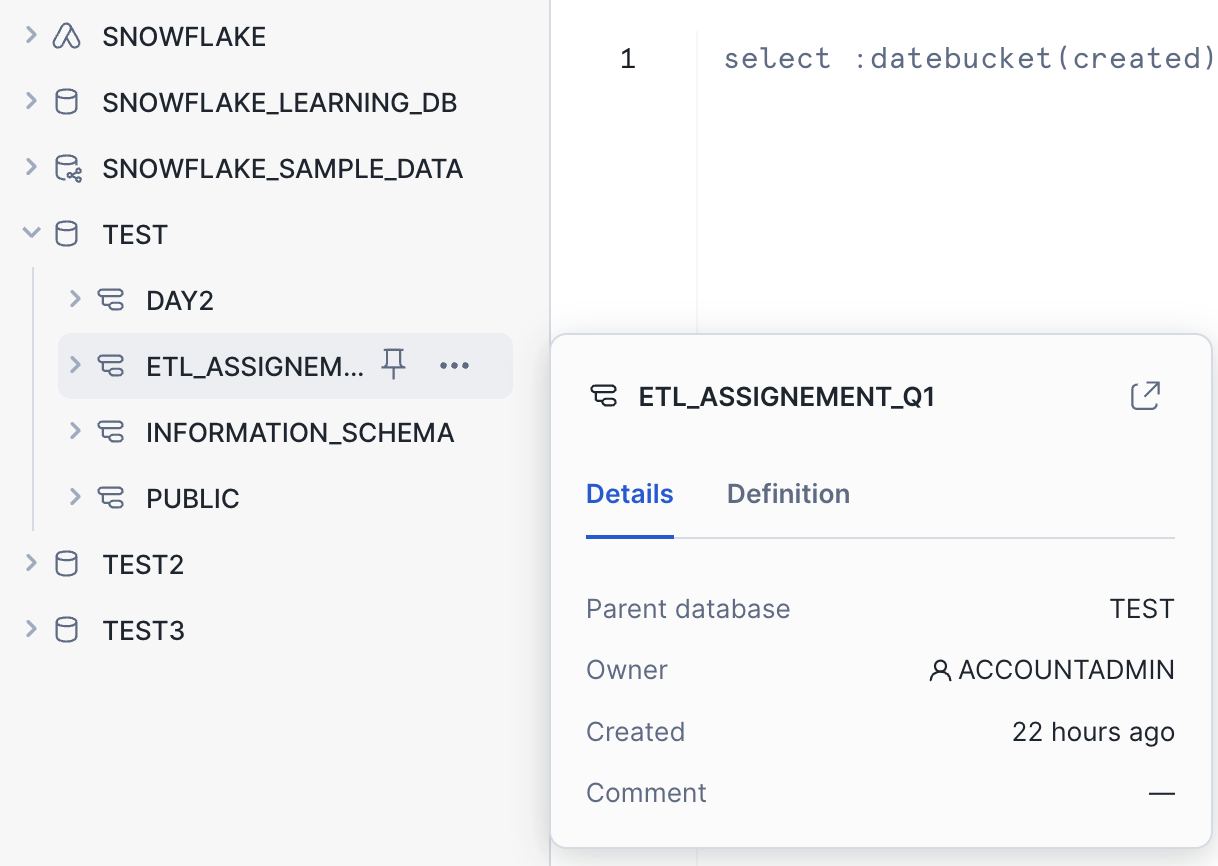

In [12]:
from IPython.display import Image

Image(filename='/Users/eleazar/Desktop/Screenshots/2025-06-03 at 12.13.00.png', width=400, height=400)

### Step 5: Load Tables in the Data Mart 
Use ``write_pandas``

In [13]:
print("\nLoading Tables into TEST.ETL_ASSIGNEMENT_Q1")

# Create tables
try:
    cur.execute("""
    CREATE TABLE IF NOT EXISTS TEST.ETL_ASSIGNEMENT_Q1.EMPLOYEES (
        ID INT,
        NAME STRING,
        DEPARTMENT STRING,
        SALARY INT
    )
    """)
    cur.execute("""
    CREATE TABLE IF NOT EXISTS TEST.ETL_ASSIGNEMENT_Q1.POSTS (
        ID INT,
        TITLE STRING,
        BODY STRING
    )
    """)
    cur.execute("""
    CREATE TABLE IF NOT EXISTS TEST.ETL_ASSIGNEMENT_Q1.ACCOUNTS (
        ID INT,
        NAME STRING,
        SALES_REP_ID INT
    )
    """)
    print("Tables EMPLOYEES, POSTS, and ACCOUNTS created.")
except Exception as e:
    print(f"Error creating tables: {e}")
    cur.close()
    conn.close()
    exit(1)


Loading Tables into TEST.ETL_ASSIGNEMENT_Q1
Tables EMPLOYEES, POSTS, and ACCOUNTS created.


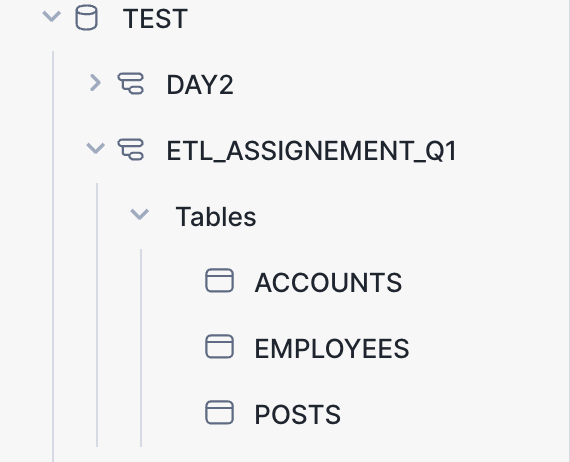

In [14]:
Image(filename='/Users/eleazar/Desktop/Screenshots/2025-06-03 at 12.59.00.png', width=400, height=400)

In [ ]:
# Verify data
#print("\nVerifying Loaded Data")
#try:
#    cur.execute("SELECT * FROM TEST.ETL_ASSIGNEMENT_Q1.EMPLOYEES")
#    print("EMPLOYEES Table:")
#    print(pd.DataFrame(cur.fetchall(), columns=['ID', 'NAME', 'DEPARTMENT', 'SALARY']))
#    cur.execute("SELECT * FROM TEST.ETL_ASSIGNEMENT_Q1.POSTS")
#    print("POSTS Table:")
#    print(pd.DataFrame(cur.fetchall(), columns=['ID', 'TITLE', 'BODY']))
#    cur.execute("SELECT * FROM TEST.ETL_ASSIGNEMENT_Q1.ACCOUNTS")
#    print("ACCOUNTS Table:")
#    print(pd.DataFrame(cur.fetchall(), columns=['ID', 'NAME', 'SALES_REP_ID']))
#except Exception as e:
#    print(f"Error verifying data: {e}")
#    cur.close()
#    conn.close()
#    exit(1)

In [ ]:
# Clean up
# cur.close()
# conn.close()
# os.remove('employees_load.csv')
# os.remove('posts_load.csv')
# os.remove('accounts_load.csv')
# print("\nConnection closed and temporary files removed.")